# RNN BUILD

* Først hente og rense data ved bruk av eget lib
* Så sette opp en modell
* Trene og validere -> Deretter teste på ny data
* Lagre modellen

Ops ops: Modellen kan kun bukes på data med 3 dimensjoner. Det betyr at det alltid på komme i en sekvens på minimum (2, 30, 5)

In [154]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt
import pickle
import math

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from lib.rens import rens
from lib.create_dataset import create_dataset
from lib.make_ready import make_ready


In [132]:
# Pickle save and load premake file.
#import pickle
#with open('premade_data/79dager.pkl', 'wb') as f:
#    pickle.dump(data, f)
    
# Load
with open('premade_data/79dager.pkl', 'rb') as f:
    data = pickle.load(f)

In [133]:
def r2_score_nn(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def add_data(word):
    ordet = 'data/' + word
    return ordet

In [6]:
indikatorer = ['macd', 'rsi_6', 'rsi_10', 'rsi_20', 'rsi_60', 
               'open_4_sma', 'open_8_sma', 'open_15_sma', 'open_16_sma', 'open_30_sma', 'open_60_sma',
               'trix', 'open_10_trix', 'open_30_trix', 'open_60_trix', 
               'wr_10', 'wr_20', 'wr_60', 'open_30_mstd', 'vr_30_sma',
               'volume', 'dma', 'atr_30', 'adx_30_ema', 'adx', 'adxr', 'cci_30']

In [6]:
#len(os.listdir('data/')) # sjekk antall filer
filer = list(map(add_data, os.listdir('data/')))[0:2] # test 54:60 mellom 10 og 14 er noe feil
data = make_ready().use_stockstats(filer)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [134]:
data[0]

,tid,open,close,high,low,volume,amount,close_-1_s,close_-1_d,rs_20,...,open_16_sma,macd,macds,macdh,open_30_sma,open_15_sma,sma8-16,sma30_derivert,sma15_derivert,derivert
0,9:0,239.0,239.0,239.0,239.0,5179,5179,0.5,0.5,0.500000,...,239.000000,0.000000,0.000000,0.000000,239.000000,239.000000,0.0000,1.000000,1.000000,1.000000
1,9:1,239.2,239.2,239.2,239.2,180,180,239.0,0.2,0.500000,...,239.100000,0.004487,0.002493,0.001994,239.100000,239.100000,0.0000,1.000000,1.000000,1.000000
2,9:2,241.0,241.0,241.0,241.0,2396,2396,239.2,1.8,0.500000,...,239.733333,0.061535,0.026691,0.034845,239.733333,239.733333,0.0000,1.002649,1.002649,1.007525
3,9:3,242.2,242.2,242.2,242.2,3733,3733,241.0,1.2,0.500000,...,240.350000,0.129300,0.061450,0.067850,240.350000,240.350000,0.0000,1.002572,1.002572,1.004979
4,9:4,245.2,245.2,245.2,245.2,2865,2865,242.2,3.0,0.500000,...,241.320000,0.282776,0.127289,0.155487,241.320000,241.320000,0.0000,1.004036,1.004036,1.012386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,16:16,240.4,240.4,240.4,240.4,14,14,240.2,0.2,1.137037,...,240.187500,0.254409,0.255595,-0.001187,239.526667,240.200000,0.2125,1.000278,1.000111,1.000833
373,16:17,240.4,240.4,240.4,240.4,2320,2320,240.4,0.0,1.137037,...,240.212500,0.251285,0.254733,-0.003448,239.580000,240.213333,0.1375,1.000223,1.000056,1.000000
374,16:18,240.4,240.4,240.4,240.4,433,433,240.4,0.0,1.137037,...,240.225000,0.245974,0.252981,-0.007008,239.640000,240.266667,0.0750,1.000250,1.000222,1.000000
375,16:19,239.6,239.6,239.6,239.6,5663,5663,240.4,-0.8,0.876858,...,240.225000,0.175192,0.237424,-0.062232,239.726667,240.266667,-0.0250,1.000362,1.000000,0.996672


In [135]:
def prepare_data_for_training(data):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.extend(datax)
        datayes.extend(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)


def prepare_data_for_test(data):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.append(datax)
        datayes.append(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)
    
    
dataxes, datayes = prepare_data_for_training(data)

In [ ]:
# Lagre i pckl for orion
with open('premade_data/X_88dager.pkl', 'wb') as f:
    pickle.dump(dataxes, f)
    
with open('premade_data/y_88dager.pkl', 'wb') as f:
    pickle.dump(datayes, f)

In [137]:
# split in train and val for training
X_train, X_test, y_train, y_test = train_test_split(dataxes, datayes, test_size=0.2, shuffle=True, random_state=42)
X_train.shape

(20068, 30, 5)

## Lage modellen
Bruker LSTM. gode greier. Har ikke gridsearched eller kfold.

In [156]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(30,5)))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(10))

model.compile(optimizer='adam', loss='mse', metrics=['mae', r2_score_nn])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 64)            1024      
_________________________________________________________________
lstm_22 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
dropout_21 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                650       
Total params: 67,722
Trainable params: 67,722
Non-trainable params: 0
_________________________________________________

In [157]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64, verbose=1)

Train on 20068 samples, validate on 5018 samples
Epoch 1/5
20068/20068 [==============================] - 20s 1ms/sample - loss: 0.1209 - mae: 0.2325 - r2_score_nn: 0.5110 - val_loss: 0.1050 - val_mae: 0.2119 - val_r2_score_nn: 0.5807
Epoch 2/5
20068/20068 [==============================] - 15s 756us/sample - loss: 0.0958 - mae: 0.2084 - r2_score_nn: 0.6094 - val_loss: 0.0846 - val_mae: 0.1973 - val_r2_score_nn: 0.6574
Epoch 3/5
20068/20068 [==============================] - 15s 730us/sample - loss: 0.0849 - mae: 0.1972 - r2_score_nn: 0.6490 - val_loss: 0.0863 - val_mae: 0.1976 - val_r2_score_nn: 0.6422
Epoch 4/5
20068/20068 [==============================] - 16s 778us/sample - loss: 0.0769 - mae: 0.1889 - r2_score_nn: 0.6847 - val_loss: 0.0731 - val_mae: 0.1855 - val_r2_score_nn: 0.6954
Epoch 5/5
20068/20068 [==============================] - 18s 915us/sample - loss: 0.0724 - mae: 0.1846 - r2_score_nn: 0.6987 - val_loss: 0.0673 - val_mae: 0.1786 - val_r2_score_nn: 0.7204


### Plotte validation kurve

max val_r2 0.7199201583862305


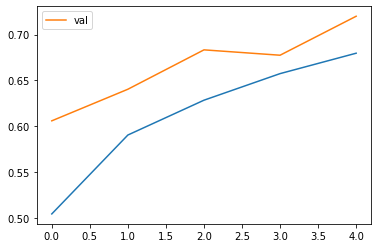

In [143]:
plt.plot(history.history['r2_score_nn'])
plt.plot(history.history['val_r2_score_nn'], label="val")
plt.legend()
#plt.xlim(50,100)

#plt.ylim(0.0, 0.025)
print(f"max val_r2 {np.max(history.history['val_r2_score_nn'])}")

### Gjennomføre en tes 
Henter helt nye data for å gjennomføre en test på modellen.

In [145]:
len(list(map(add_data, os.listdir('data/'))))

99

In [146]:
filer = list(map(add_data, os.listdir('data/')))[90:99] # test 54:60
data_test = make_ready().use_stockstats(filer)
dataxes, datayes = prepare_data_for_test(data_test)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
C:\Users\Stian\anaconda3\lib\site-packages\ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [147]:
dataxes.shape

(9,)

In [150]:
pred = []
for x in dataxes:
    pred.append(model.predict(x))

pred = np.array(pred)

C:\Users\Stian\anaconda3\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


In [151]:
pred.shape

(9,)

In [152]:
for i in range(len(pred)):
    print(f"rscore for one of it {r2_score(pred[i], datayes[i])}")
    

rscore for one of it 0.5323977332706381
rscore for one of it 0.7337612777076654
rscore for one of it 0.3579615829566455
rscore for one of it 0.21853082066983237
rscore for one of it 0.6162125260500247
rscore for one of it 0.26317950244257293
rscore for one of it 0.3989653944490705
rscore for one of it 0.49778678785632274
rscore for one of it 0.6337499057860733


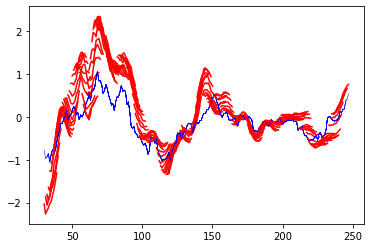

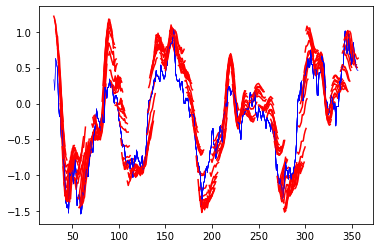

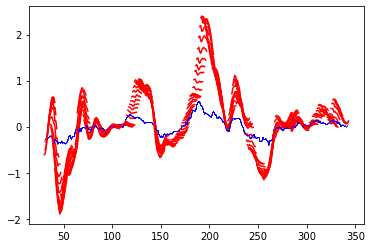

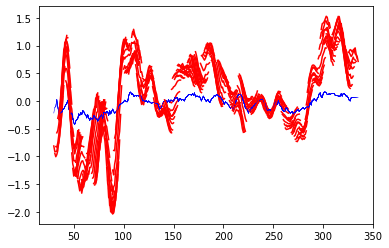

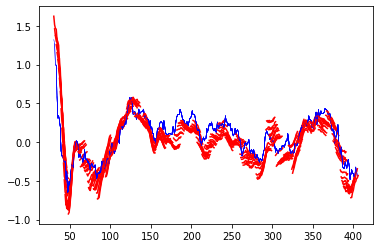

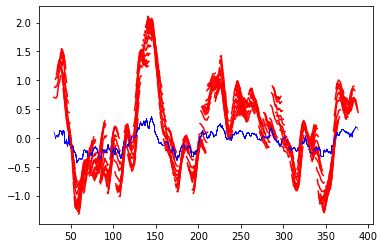

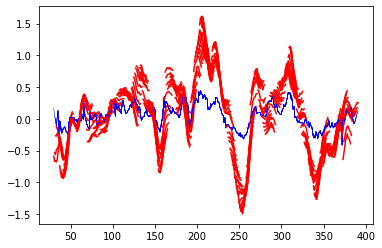

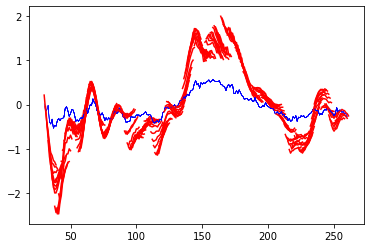

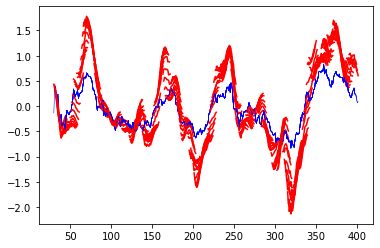

In [153]:
for i, p in enumerate(pred):
    for j, y in enumerate(p):

        plt.plot(range(30+j,40+j), datayes[i][j], c='blue', linewidth=.5)
        plt.plot(range(30+j,40+j), y, c='red')
    plt.show()

In [ ]:
plt.plot(data[0]['open'])

## Save model

In [ ]:
# Save model

model.save('models/rnn_model.h5')

In [ ]:
!dir